In [1]:
%matplotlib inline

# Ultrasound imaging simulation

Use NDK to simulate the image captured by an ultrasound transducer.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import stride
import tqdm.notebook

import neurotechdevkit as ndk
from neurotechdevkit.scenarios import (
    Target,
    make_grid,
    create_grid_circular_mask,
    materials,
)
from neurotechdevkit.sources import PhasedArraySource2D

# Local modules
import demodulate
import beamform
import util
from scenario import ImagingScenario2D

In [3]:
# Scenario parameters
SPEED_OF_SOUND_WATER = 1500  # meters per second
WATER_HETEROGENEITY = 1.0  # arbitrary units, determines how much the acoustic impedance varies in the water
# Increasing WATER_HETEROGENEITY increases the amount of speckle in the image due to increased scattering.

# Plane-wave pulse parameters
TONE_CENTER_FREQUENCY = 0.5e6  # Hz
TILT_ANGLES_DEG = np.linspace(start=-10, stop=10, endpoint=True, num=5)  # Plane-wave pulses

# Phased array transducer parameters
ARRAY_PITCH=300e-6
ARRAY_ELEMENT_WIDTH=270e-6
ARRAY_NUM_ELEMENTS=128
TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH = 0.5  # transmit/receive frequency bandwidth as a fraction of center frequency

# Arbitrary constants
SAMPLING_POINTS_PER_PERIOD = 24

RANDOM_SEED = 58295  # Use if we need the specific function to be deterministic
rng = np.random.default_rng(seed=58295)  # Use if we only need the notebook to be deterministic

## Define a scenario.

Create a basic scenario with 2 agar hydrogel phantoms in water, imaged by a linear array.

Note: the "Target" is not meaningful in this case.

In [4]:
_PHANTOM_RADIUS = 0.01  # m
_AGAR_PHANTOM_CENTERS = np.array([
    [0.06, 0.0],
    [0.07, 0.03],
])


class ImagingCirclesScenario(ImagingScenario2D):
    """Imaging Scenario: grainy phantoms in water."""

    _SCENARIO_ID = "imaging-scenario-2d-v0"
    _TARGET_OPTIONS = {
        "agar-phantom-0": Target(
            target_id="agar-phantom-0",
            center=_AGAR_PHANTOM_CENTERS[0],
            radius=_PHANTOM_RADIUS,
            description="First imaging phantom.",
        ),
        "agar-phantom-1": Target(
            target_id="agar-phantom-1",
            center=_AGAR_PHANTOM_CENTERS[1],
            radius=_PHANTOM_RADIUS,
            description="Second imaging phantom.",
        ),
    }
    material_layers = [
        "water",
        "agar_hydrogel",
    ]
    material_properties = {
        "water": materials.Material(
            vp=materials.DEFAULT_MATERIALS["water"].vp,
            rho=materials.DEFAULT_MATERIALS["water"].rho,
            alpha=0.001,
            render_color="#2E86AB",
            # Add heterogeneity to model irregularities
            vp_std=WATER_HETEROGENEITY,
            rho_std=WATER_HETEROGENEITY,
        ),
        "agar_hydrogel": materials.Material(
            # These values are loosely based on:
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5452295/table/Tab2/
            vp=1485.0, rho=1050.0, alpha=0.1, render_color="#E9E6C9",
            # Add heterogeneity to the agar phantom to cause scattering
            vp_std=12.0, rho_std=10.0,
        ),
    }

    def __init__(self, complexity="fast"):
        """Create a new instance of scenario 3."""
        self._target_id = "agar-phantom-0"
        self._extent = np.array([0.1, 0.1])  # m

        super().__init__(
            origin=np.array([0.0, -self._extent[1] / 2]),
            complexity=complexity,
        )

    @property
    def _material_outline_upsample_factor(self) -> int:
        return 16

    def _compile_problem(self, center_frequency: float) -> stride.Problem:

        # desired resolution for complexity=fast
        ppw = 6

        # compute resolution
        dx = SPEED_OF_SOUND_WATER / center_frequency / ppw  # m

        grid = make_grid(extent=self._extent, dx=dx)
        problem = stride.Problem(
            name=f"{self.scenario_id}-{self.complexity}", grid=grid
        )
        problem = util.add_material_fields_to_problem(
            problem=problem,
            materials=self.get_materials(center_frequency),
            layer_ids=self.layer_ids,
            masks={
                name: _create_scenario_mask(name, problem.grid, self.origin)
                for name in self.material_layers
            },
            rng=RANDOM_SEED,  # Materials have the same heterogeneity each time
        )
        return problem

    def get_default_source(self):
        """The transducer source for the scenario."""
        return PhasedArraySource2D(
            position=np.array([0.003, 0.0]),
            direction=np.array([1.0, 0.0]),
            num_elements=ARRAY_NUM_ELEMENTS,
            num_points=ARRAY_NUM_ELEMENTS * 4,
            tilt_angle=0,
            pitch=ARRAY_PITCH,
            element_width=ARRAY_ELEMENT_WIDTH,
        )


def _create_scenario_mask(material, grid, origin):
    agar_phantom_mask = create_grid_circular_mask(
        grid, origin, _AGAR_PHANTOM_CENTERS[0], _PHANTOM_RADIUS
    )
    agar_phantom_mask |= create_grid_circular_mask(
        grid, origin, _AGAR_PHANTOM_CENTERS[1], _PHANTOM_RADIUS
    )
    if material == "water":
        return ~(agar_phantom_mask)

    elif material == "agar_hydrogel":
        return agar_phantom_mask 

    else:
        raise ValueError(material)


creating a grid with shape: (201, 201) for extent: [0.1 0.1] m


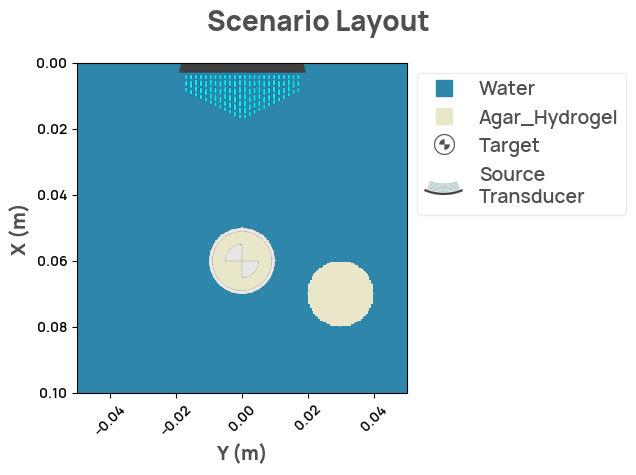

In [5]:
# Show the scenario
scenario = ImagingCirclesScenario()
scenario.render_layout()

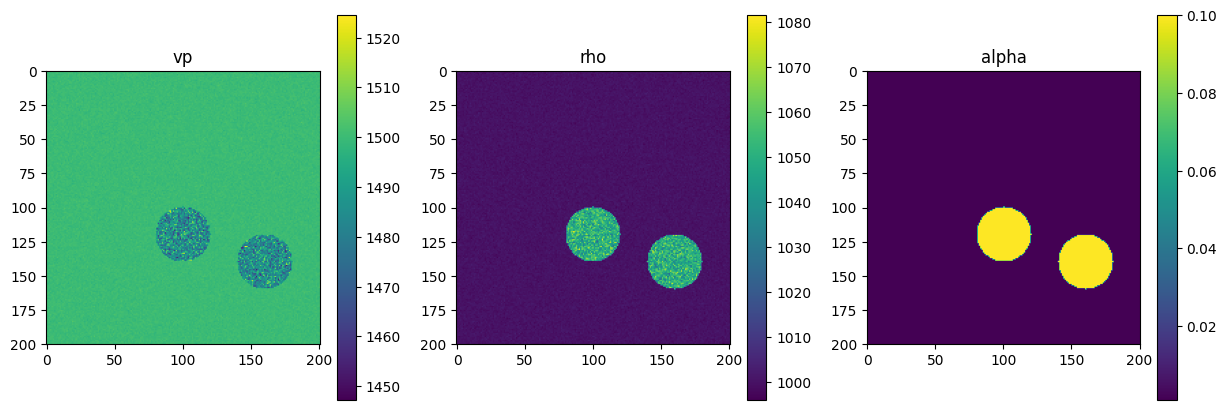

In [6]:
# Plot the relevant material metrics
# vp - speed of sound
# rho - density
# alpha - attenuation
fig,axs = plt.subplots(1,3,figsize=(15,5))

for idx, attribute in enumerate(["vp", "rho", "alpha"]):
    im = axs[idx].imshow(getattr(scenario.problem.medium, attribute).data)
    plt.colorbar(im, ax=axs[idx])
    axs[idx].set_title(attribute)

# Transmit ultrasonic plane waves
We run multiple NDK simulations, each sending an ultrasonic plane wave at the phantoms at different angles.
Each echo provides a low-resolution image of the target object. By summing the complex-valued images, the low-resolution image's phases cancel out and create a higher-resolution "compound" image.

By the way, I'm using the terms pulse/echo/plane-wave somewhat interchangeably, but more specifically pulse=`transmitted ultrasonic wave`, echo=`the sensor signals received from a given pulse`, and plane-wave=`a specific kind of pulse where the wavefront is a plane/line`

Let's first visualize the plane wave at the default tilt angle (0&deg;).

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Estimated time to complete simulation: 48 seconds. Memory required is 8.112811402326496 GB (available 68.719476736 GB). These values are approximated.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.499-0.503 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 5.750 PPW) is below dispersion limit (0.575 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 4
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.29 s
  * lowering.Clusters: 2.33 s (54.4 %)
     * specializing.Clusters: 1.40 s (32.7 %)
  * lowering.Exp

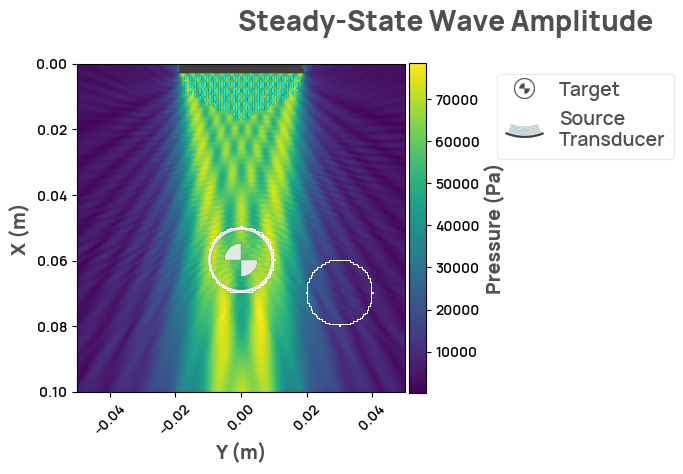

In [8]:
result = ImagingCirclesScenario().simulate_steady_state(
    center_frequency=TONE_CENTER_FREQUENCY,
)
result.render_steady_state_amplitudes()

We can see that the plane wave sonicates a large area of the medium, including the center phantom and (to a lesser extent) the phantom on the right.

In [7]:
# Send several plane waves from the transducer and measure the reflected/scattered acoustic waves
# We can then compound the different plane waves to improve the spatial resolution

results = [None] * len(TILT_ANGLES_DEG)
# keep track of the tx delays used
element_delays_list = [None] * len(TILT_ANGLES_DEG)

for idx, tilt_angle in enumerate(tqdm.notebook.tqdm(TILT_ANGLES_DEG, desc="Simulating pulses", unit="pulse")):
    # Current limitation of NDK: need to re-generate scenario to simulate a new pulse
    # https://github.com/agencyenterprise/neurotechdevkit/issues/108
    scenario = ImagingCirclesScenario()
    scenario.add_source(scenario.get_default_source())
    assert len(scenario.sources) == 1
    # Set the tilt angle, which will automatically re-calculate the element delays
    scenario.sources[0].tilt_angle = tilt_angle
    element_delays_list[idx] = scenario.sources[0].element_delays
    results[idx] = scenario.simulate_pulse(
        center_frequency=TONE_CENTER_FREQUENCY,
        points_per_period=SAMPLING_POINTS_PER_PERIOD,
        n_jobs=-2,
    )

Simulating pulses:   0%|          | 0/5 [00:00<?, ?pulse/s]

creating a grid with shape: (201, 201) for extent: [0.1 0.1] m
Memory and time requirement estimations do not currently support pulsed simulations, so none will be provided.
Default Devito configuration:
	 * autotuning=off
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.256-0.732 MHz
(ShotID 0) Spatial grid spacing (0.500 mm | 3.953 PPW) is higher than dispersion limit (0.395 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.083 μs | 25%) is below OT2 limit (0.148 μs)
(ShotID 0) Selected undersampling level 1
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 0.0005, h_y: 0.0005}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 4.41 s
  * lowering.Clusters: 2.39 s (54.4 %)
     * specializing.Clusters: 1.37 s (31.2 %)
  * lowering.Expressions: 1.09 s (24.8 %)
Flops re

## Visualizing received (simulated) signals

In a real imaging situation, we usually only have access to the RF signals measured at the ultrasound sensor elements; we don't know what's in the grid and can't access the full wavefield.

In [8]:
# The receivers at N sensor elements give us data traces of [N, num_fast_time_samples]
assert results[0].traces.data.shape == (
    ARRAY_NUM_ELEMENTS,
    len(results[0].traces.time.grid)
)
time_steps = [result.traces.time.step for result in results]
np.testing.assert_array_equal(time_steps[0], time_steps)
freq_sampling = TONE_CENTER_FREQUENCY * SAMPLING_POINTS_PER_PERIOD
assert np.allclose(time_steps[0], 1 / freq_sampling)

print("Traces shape:", results[0].traces.data.shape)
print("Time grid:", results[0].traces.time.grid)
print("Sampling frequency [Hz]: {:.2e}".format(freq_sampling))

Traces shape: (128, 2393)
Time grid: [0.0000000e+00 8.3333333e-08 1.6666667e-07 ... 1.9916666e-04 1.9925000e-04
 1.9933333e-04]
Sampling frequency [Hz]: 1.20e+07


In [9]:
# Pad RF signals to longest length, in case they are not all the same length
rf_signal_lengths = [len(result.traces.time.grid) for result in results]
rf_signal_max_len = max(rf_signal_lengths)
rf_signal_max_len_idx = np.argmax(rf_signal_lengths)
time = results[rf_signal_max_len_idx].traces.time.grid

# Shape: [num_fast_time_samples, num_elements, num_pulses]
rf_signals = np.zeros(
    (rf_signal_max_len, ARRAY_NUM_ELEMENTS, len(results)),
    dtype=float,
)
for pulse_idx, result in enumerate(results):
    rf_signals[:rf_signal_lengths[pulse_idx], :, pulse_idx] = result.traces.data.T

In [10]:
# The data at the beginning of each pulse simply contains the transmitted pulse,
# so let's remove it from the raw-data visualizations to prevent it from overwhelming the reflected image.
extra_buffer_fraction = 0.05
array_element_positions = scenario.sources[0].element_positions
distance = np.linalg.norm(array_element_positions.max() - array_element_positions.min())

for pulse_idx, element_delays in enumerate(element_delays_list):
    max_time_delay = element_delays.max()
    last_invalid_time = (1 + extra_buffer_fraction) * (distance / SPEED_OF_SOUND_WATER + max_time_delay)
    valid_time_mask = time > last_invalid_time

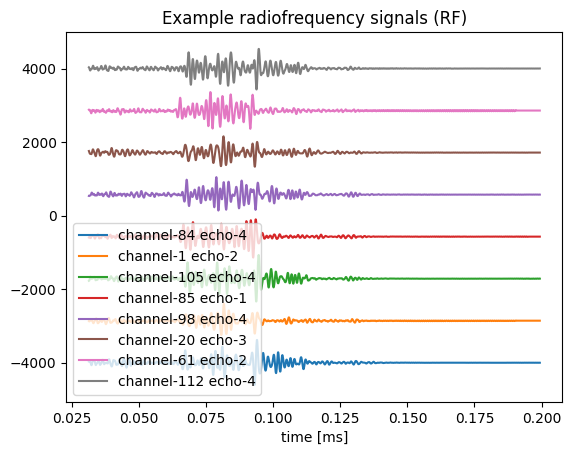

In [11]:
NUM_VISUALIZE = 8
channel_idxs = rng.integers(ARRAY_NUM_ELEMENTS, size=NUM_VISUALIZE)
pulse_idxs = rng.integers(len(TILT_ANGLES_DEG), size=NUM_VISUALIZE)

rf_signal_visualize = rf_signals[:, channel_idxs, pulse_idxs]

# Plot with some offsets
CHANNEL_OFFSET = 1000
_ = plt.plot(
    time[valid_time_mask] * 1e3,
    rf_signal_visualize[valid_time_mask] + np.linspace(-0.5, 0.5, num=NUM_VISUALIZE, endpoint=True) * NUM_VISUALIZE * CHANNEL_OFFSET,
    label=[f"channel-{channel_idx} echo-{echo_idx}" for (channel_idx, echo_idx) in zip(channel_idxs, pulse_idxs)],
)
_ = plt.legend()
_ = plt.title("Example radiofrequency signals (RF)")
_ = plt.xlabel("time [ms]")

Plotting across elements (for a single shot) shows the typical hyperbolas for each scatterer (object). 

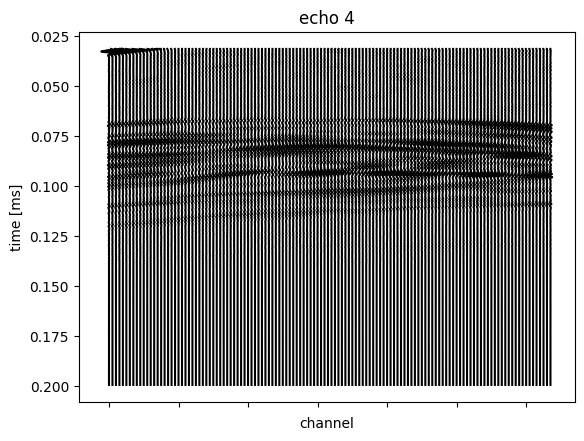

In [12]:
pulse_idx = rng.integers(len(TILT_ANGLES_DEG))

fig, ax = plt.subplots()
ax.plot(
    rf_signals[valid_time_mask, :, pulse_idx] + np.arange(ARRAY_NUM_ELEMENTS) * CHANNEL_OFFSET,
    time[valid_time_mask] * 1000,
    color='k',
)
ax.set_title(f"echo {pulse_idx}")
ax.set_xticklabels([])  # We added values for offset, so values don't mean anything
ax.set_ylabel("time [ms]")
ax.set_xlabel("channel")
ax.invert_yaxis()

This helps to visualize the slight time-offsets of each array element in receiving the echoes.

## Image reconstruction

In multi-plane imaging, each pulse-echo image is constructed separately, then added together.

Similar to the single-pulse `109-ultrasound-imaging.ipynb` notebook, this notebook demodulates the RF signals to I/Q and then beamforms to create each pulse-echo frame.

In [13]:
iq_signals, _ = demodulate.demodulate_rf_to_iq(
    rf_signals,
    freq_sampling,
    freq_carrier=TONE_CENTER_FREQUENCY,
    bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
)

assert iq_signals.shape == rf_signals.shape

In [14]:
# Beam-form I/Q signals into an image

assert len(scenario.sources) == 1
source = scenario.sources[0]
assert isinstance(source, ndk.sources.PhasedArraySource)
pitch = source.pitch
width = source.element_width
empirical_pitch = np.linalg.norm(np.diff(results[0].shot.receiver_coordinates, axis=0), axis=1)
np.testing.assert_allclose(empirical_pitch, pitch, rtol=1e-2)

# Generate an image at the scenario grid
# NOTE: .mesh uses different x/y space
x_mesh, y_mesh = results[0].shot.grid.space.mesh

# Switch to imaging convention: x for parallel-to-array, z for depth
imaging_x_mesh = y_mesh + scenario.origin[1]
imaging_z_mesh = x_mesh + scenario.origin[0]

iq_signals_beamformed_list = []
for idx, tilt_angle in enumerate(TILT_ANGLES_DEG):
    iq_signals_beamformed = beamform.beamform_delay_and_sum(
        iq_signals[:, :, idx],
        x=imaging_x_mesh,
        z=imaging_z_mesh,
        pitch=pitch,
        tx_delays=element_delays_list[idx],
        freq_sampling=freq_sampling,
        freq_carrier=TONE_CENTER_FREQUENCY,
        f_number=None,
        width=width,
        bandwidth=TRANSDUCER_6DB_PULSE_ECHO_FRACTIONAL_BANDWIDTH,
        speed_sound=SPEED_OF_SOUND_WATER,  # water
    )
    iq_signals_beamformed_list.append(iq_signals_beamformed)

iq_signals_beamformed_compound = np.stack(iq_signals_beamformed_list, axis=-1)
iq_signals_beamformed_compound.shape

(201, 201, 5)

## Visualize reconstructed image

In [15]:
def plot_ultrasound_image(x_mesh, z_mesh, iq_signals_bf, db=40):
    plt.pcolormesh(
        x_mesh,
        z_mesh,
        util.log_compress(iq_signals_bf, db),
        cmap='gray',
    )
    cbar = plt.colorbar(ticks=[0, 1])
    cbar.ax.set_yticklabels([f"-{db} dB", "0 dB"])  # horizontal colorbar

    plt.axis('equal')
    plt.gca().invert_yaxis()  # Invert the y-axis to flip the image vertically
    plt.title('Log-compressed image')
    plt.xlabel('[m]')
    plt.ylabel('[m]')

In [16]:
DB_VIS = 30

Text(0.5, 1.0, 'Single pulse-echo image')

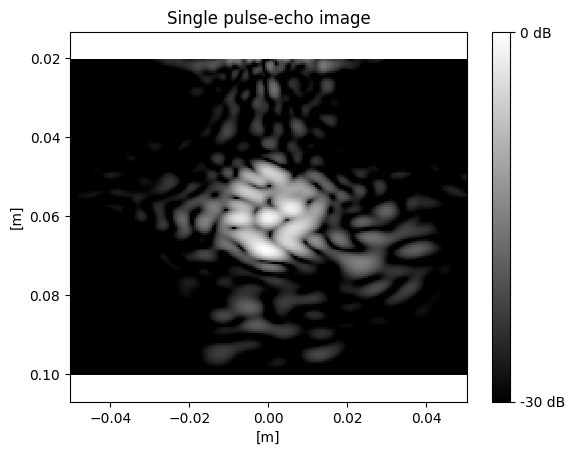

In [17]:
mask = (imaging_z_mesh > 0.02).all(axis=1)

plot_ultrasound_image(
    imaging_x_mesh[mask],
    imaging_z_mesh[mask],
    iq_signals_beamformed_compound[mask, :, len(TILT_ANGLES_DEG) // 2],
    db=DB_VIS
)
plt.title("Single pulse-echo image")

A single plane-wave pulse is unfocused, so the image is blurry. On the other hand, it sonicates a larger area than a focused ultrasound beam (a.k.a. "scan line"), so it includes both the center circle and the right circle (blurrily).

Text(0.5, 1.0, 'Compound image')

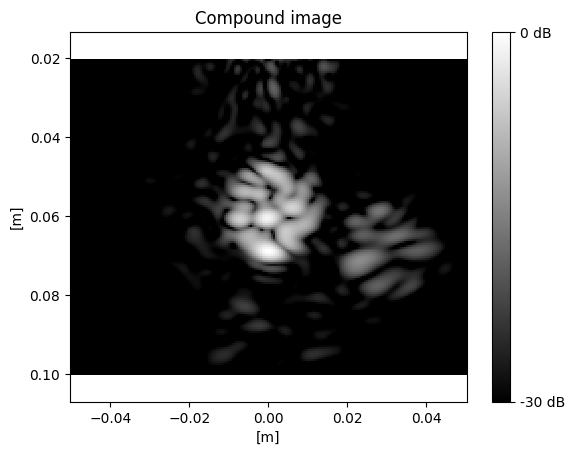

In [18]:
plot_ultrasound_image(
    imaging_x_mesh[mask],
    imaging_z_mesh[mask],
    iq_signals_beamformed_compound[mask].sum(axis=-1),
    db=DB_VIS
)
plt.title("Compound image")

Compounding multiple plane waves improves the image focus.

The speckles in the image are a normal part of B-mode imaging.
Additionally, the phantom on the right experiences a slight "shadow," because not all of the plane waves reach it. If we increase the width of the array so that the plane waves are wider, we would get better coverage of the phantom on the right.